## Fitting the data

In [68]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import FSPLarge_model, PSPL_model, FSPL_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.fits import DE_fit, MCMC_fit, LM_fit
from pyLIMA.toolbox.brightness_transformation import flux_to_magnitude, magnitude_to_flux
import matplotlib.pyplot as plt
import numpy as np
import corner

In [69]:
data = np.load("../tutorials/assets/microlensing_dat.npz")["data"]

# Microlensing Physical Parameters
th_ein = 0.1  # Einstein radius in arcsec

# Microlensing Model Parameters
t0 = 0.2  # time at peak magnification
u0 = 0.5 * th_ein  # minimum impact parameter (u(t=t_0)) in units of th_ein
tE = 0.05 # Einstein timescale
rho = 3.0  # source size in units of lens Einstein radii

gamma = 0.0  # linear limb darkening coefficient

In [70]:
your_event = event.Event()
your_event.name = "Simulated Event"
telescope = telescopes.Telescope(
    name="test",
    light_curve=data,
    light_curve_names=["time", "flux", "err_flux"],
    light_curve_units=["s", "flux", "err_flux"],
)

your_event.telescopes.append(telescope)
# your_event.telescopes[0].ld_gamma = 0.5
your_event.find_survey("test")
your_event.check_event()

fspl = FSPLarge_model.FSPLargemodel(your_event)

fspl_fit = DE_fit.DEfit(
    fspl, DE_population_size=10, loss_function="chi2", max_iteration=10000
)

check_event  : Everything looks fine...


In [71]:
pyLIMA_parameters = fspl.compute_pyLIMA_parameters([t0, u0, tE, rho])
list_of_telescopes = pyLIMA_plots.create_telescopes_to_plot_model(fspl,
                                                         pyLIMA_parameters)
tel = list_of_telescopes[0]


In [72]:
model_magnification = fspl.model_magnification(tel, pyLIMA_parameters=pyLIMA_parameters)
fspl.derive_telescope_flux(tel, pyLIMA_parameters, model_magnification)
pyLIMA_parameters['fsource_test'] = 1.0
pyLIMA_parameters['fblend_test'] = 0.0
pyLIMA_parameters['gblend_test'] = 0.0

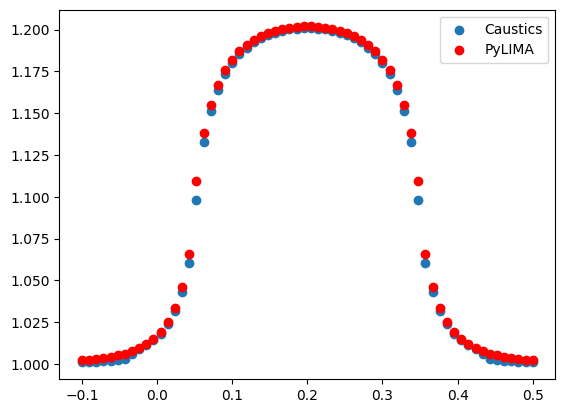

In [73]:
# !The model predicts higher magnification than the sim. The smaller rho, the worse the discrepancy. 
# I independently calculated magnification using direct integration and matched caustics. Seems like an issue with pyLIMA at small rho for both FSPL and FSPLarge.

true_dict = {"t0": t0, "u0": u0, "tE": tE, "rho": rho}
# model_magnification = fspl.model_magnification(telescope, pyLIMA_parameters=true_dict)
model_magnification = fspl.model_magnification(telescope, pyLIMA_parameters=pyLIMA_parameters)

magnitude = pyLIMA_parameters['fsource_test'] * model_magnification + pyLIMA_parameters['fblend_test'] 

plt.scatter(data[:,0], data[:,1], label='Caustics')
plt.scatter(data[:,0], magnitude, color="red", label="PyLIMA")
# plt.scatter(data[:,0], magnitude/data[:,1], color="red")
plt.legend()

plt.show()

In [74]:
# t_E  u0   tE  rho
fspl_fit.fit_parameters["tE"][1] = (0.0, 2)
fspl_fit.fit_parameters["u0"][1] = (0.0, 2)
fspl_fit.fit_parameters["rho"][1] = [0.1, 10]
guess_parameters = [0.2, 0.3, 0.3, 1]
fspl_fit.model_parameters_guess = guess_parameters

fspl_fit.fit()

DE converge to objective function : f(x) =  0.06606452434333863
DE converge to parameters : =  ['0.1998497870151444' '1.2912954218523929' '0.04724742129125947'
 '3.390226913687818']
fit  : Differential Evolution fit SUCCESS
best_model: [0.19984979 1.29129542 0.04724742 3.39022691] chi2 0.06606452434333863


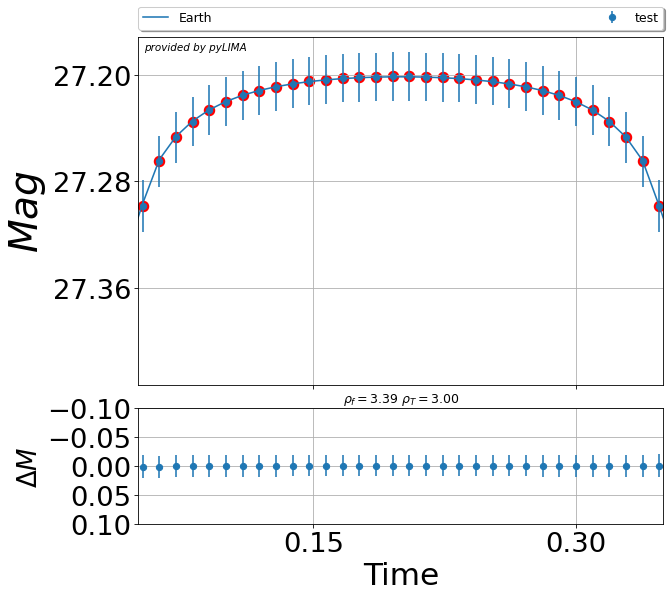

In [75]:
fig,ax = pyLIMA_plots.plot_lightcurves(fspl, fspl_fit.fit_results["best_model"])

plt.xlim(-3 * tE + t0, 3 * tE + t0)
plt.title(
    r"$\rho_f = {:.2f}$".format(fspl_fit.fit_results["best_model"][3])
    + r" $\rho_T = {:.2f}$".format(rho)
)
plt.xlabel("Time", fontsize=30)
fig.axes[0].scatter(data[:,0], flux_to_magnitude(data[:,1]), color="red",linewidths=5)
plt.show()

In [77]:
fspl_fit.fit_results["best_model"] / [t0, u0, tE, rho]

array([ 0.99924894, 25.82590844,  0.94494843,  1.13007564])

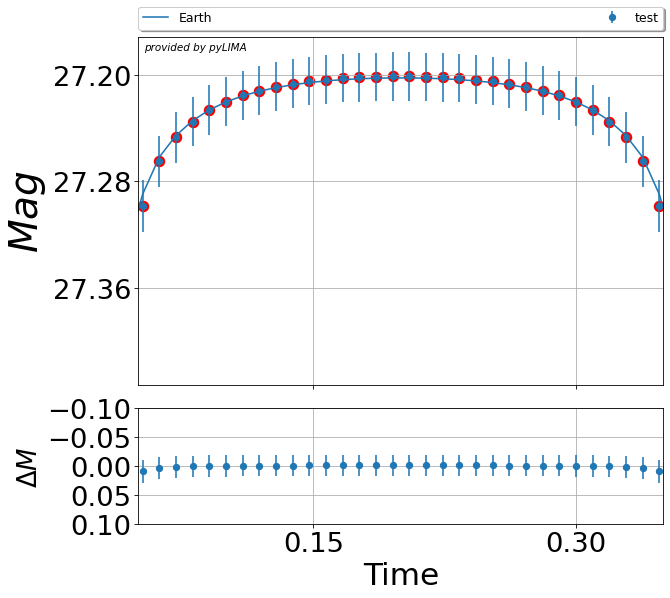

In [78]:
fig,ax = pyLIMA_plots.plot_lightcurves(fspl, [t0, u0, tE, rho])

plt.xlim(-3 * tE + t0, 3 * tE + t0)
plt.xlabel("Time", fontsize=30)

fig.axes[0].scatter(data[:,0], flux_to_magnitude(data[:,1]), color="red",linewidths=5)
plt.show()

## MCMC

In [90]:
fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function="chi2")
# fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function="likelihood")
fspl_mcmc_fit.fit_parameters["t0"][1] = (-1, 1)
fspl_mcmc_fit.fit_parameters["tE"][1] = (0.0, 1)
fspl_mcmc_fit.fit_parameters["u0"][1] = [0.0, 2*rho]
fspl_mcmc_fit.fit_parameters["rho"][1] = [0.0, 5]

# Initialize MCMC with best parameters of DE fit
fspl_mcmc_fit.model_parameters_guess = fspl_fit.fit_results["best_model"]

fspl_mcmc_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.1998497870151444, 1.2912954218523929, 0.04724742129125947, 3.390226913687818]


100%|██████████| 5000/5000 [00:15<00:00, 325.25it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [ 0.19996176  0.94908488  0.04973039  3.12251453  1.09674729 -0.09859233] chi2 -0.04751445592047864


In [91]:
MCMC_results = fspl_mcmc_fit.fit_results["MCMC_chains"]
print("Parameters", " Model", "   Fit", "     Errors")
print("-----------------------------------")
print(
    "t_0:",
    "        " + str(t0) + "  ",
    str(np.median(MCMC_results[1000:, :, 0]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 0]))[:7],
)
print(
    "u_0:",
    "        " + str(u0) + "  ",
    str(np.median(MCMC_results[1000:, :, 1]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 1]))[:7],
)
print(
    "t_E:",
    "        " + str(tE) + " ",
    str(np.median(MCMC_results[1000:, :, 2]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 2]))[:7],
)
print(
    "rho:",
    "        " + str(rho) + "  ",
    str(np.median(MCMC_results[1000:, :, 3]))[:7],
    "",
    str(np.std(MCMC_results[1000:, :, 3]))[:7],
)

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         0.2   0.19980  0.00152
u_0:         0.05   1.24627  0.88991
t_E:         0.05  0.04675  0.00890
rho:         3.0   3.45330  0.73856


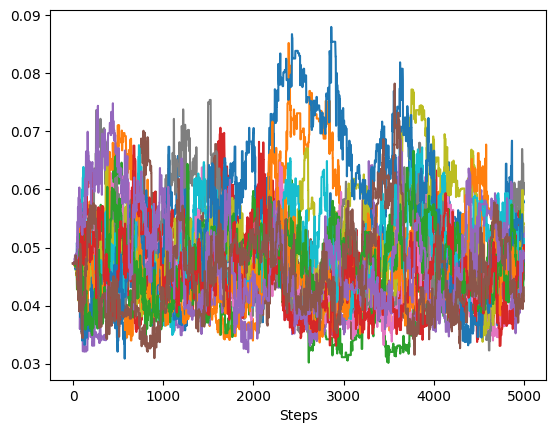

In [95]:
plt.plot(fspl_mcmc_fit.fit_results["MCMC_chains"][:, :, 2])
plt.xlabel("Steps")
# plt.ylabel("rho")
plt.show()

In [96]:
burn_in = 2000
MCMC_results_pruned = MCMC_results[burn_in:, :, :]
reshaped_results = MCMC_results_pruned.reshape(-1, 5)

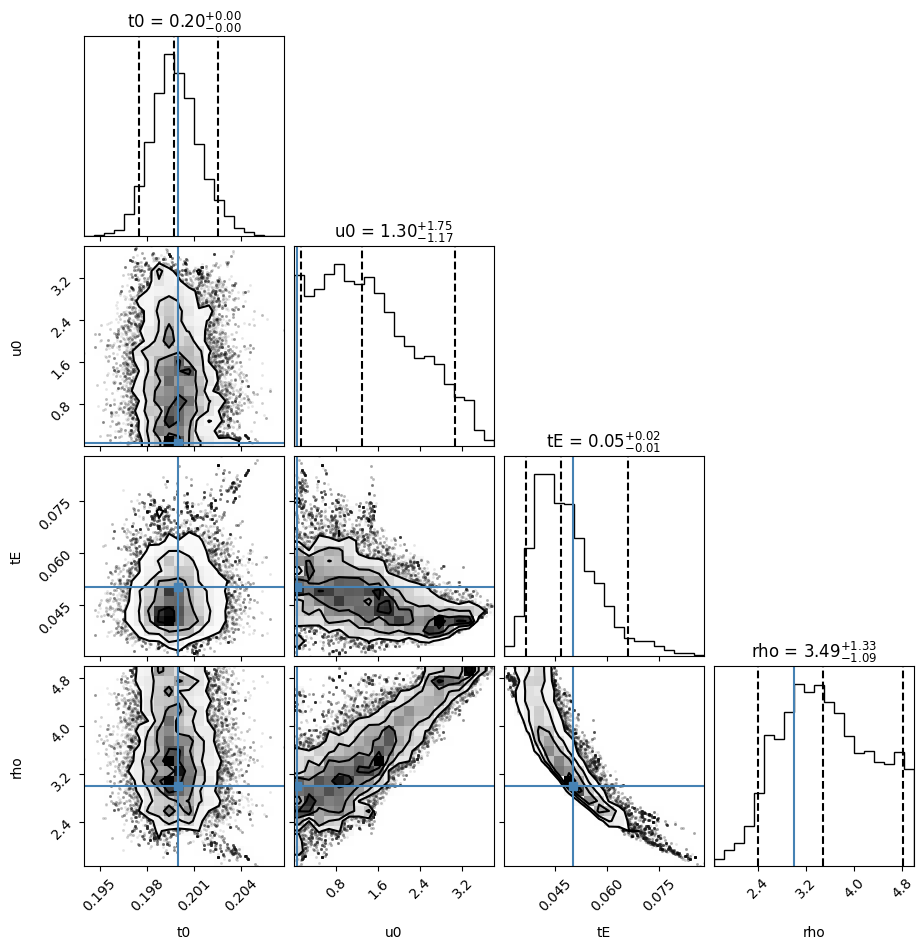

In [97]:
fspl_mcmc_fit.fit_parameters.keys()
figure = corner.corner(
    reshaped_results[:, 0:4],
    labels=[label for label in fspl_mcmc_fit.fit_parameters.keys()],
    quantiles=[0.05, 0.5, 0.95],
    truths=[t0, u0, tE, rho],
    show_titles=True,
    # range=[
    #     (0.99 * t0, 1.01 * t0),
    #     (0.5 * u0, 1.5 * u0),
    #     (0.5 * tE, 1.5 * tE),
    #     (0.8*rho, 1.2 * rho),
    # ],
)

In [98]:
mcmc_best_fit_params = np.median(reshaped_results, axis=0)

true_parameters = [t0, u0, tE, rho]

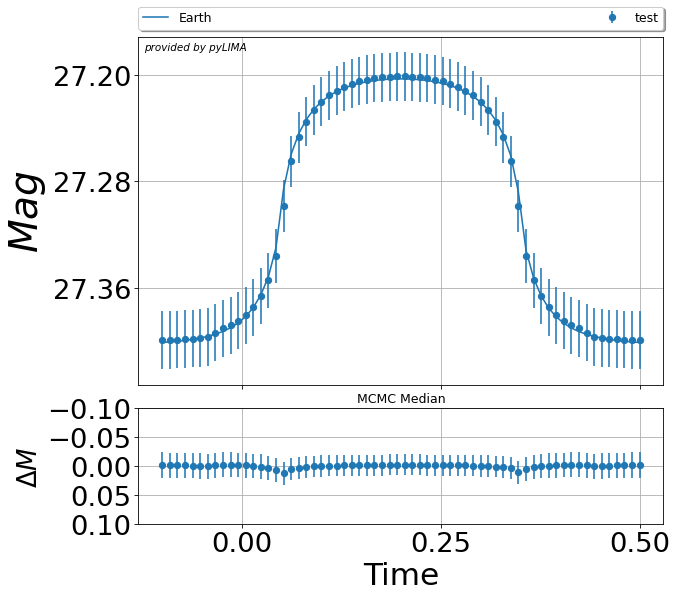

In [99]:
fig = pyLIMA_plots.plot_lightcurves(fspl, mcmc_best_fit_params[:4])

plt.title("MCMC Median")
plt.xlabel("Time", fontsize=30)
plt.show()